In [1]:
import os
import sys
import math
import time
import random

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from vizdoom import *
from IPython.display import clear_output
from collections import namedtuple, deque

%matplotlib inline

In [2]:
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../chillmonger/'))
sys.path.insert(0, os.path.abspath('../external_lib/ViZDoom/'))

In [3]:
from chillmonger.agents import PPOAgent
from chillmonger.models import ActorCnn, CriticCnn
from chillmonger.preprocessing.stack_frame import preprocess_frame, stack_frame

### Constants

In [4]:
CFG = "../resources/cfg/defend_the_center.cfg"
WAD = "../resources/cfg/defend_the_center.wad"

### Step 2: Create our environment
### Initialize the environment in the code cell below.

In [5]:
def create_environment():
    game = DoomGame()
    
    # Load the correct configuration
    game.load_config(CFG)
    
    # Load the correct scenario (in our case defend_the_center scenario)
    game.set_doom_scenario_path(WAD)
    
    possible_actions  = np.identity(3,dtype=int).tolist()
    
    return game, possible_actions

In [6]:
game, possible_actions = create_environment()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


### Step 3: Viewing our Enviroment

The size of frame is: ( 480 ,  640 )
No. of Actions:  [[1, 0, 0], [0, 1, 0], [0, 0, 1]]


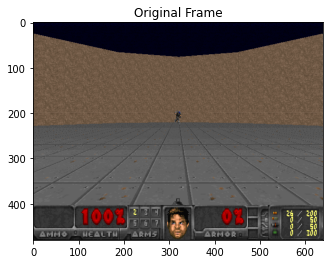

In [10]:
print("The size of frame is: (", game.get_screen_height(), ", ", game.get_screen_width(), ")")
print("No. of Actions: ", possible_actions)
game.init()
plt.figure()
plt.imshow(game.get_state().screen_buffer.transpose(1, 2, 0))
plt.title('Original Frame')
plt.show()
game.close()

### Execute the code

In [11]:
def random_play():
    game.init()
    game.new_episode()
    score = 0
    while True:
        reward = game.make_action(possible_actions[np.random.randint(3)])
        done = game.is_episode_finished()
        score += reward
        time.sleep(0.01)
        if done:
            print("Your total score is: ", score)
            game.close()
            break
random_play()

Your total score is:  0.0


### Step 4: Preprocessing Frame

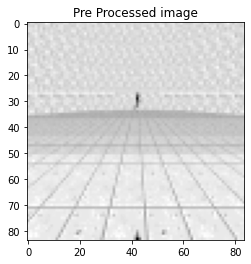

In [12]:
game.init()
plt.figure()
plt.imshow(preprocess_frame(game.get_state().screen_buffer.transpose(1, 2, 0),(100, -12, -80, 4), 84), cmap="gray")
game.close()
plt.title('Pre Processed image')
plt.show()

### Step 5: Stacking Frame


In [13]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (100, -12, -80, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

### Step 6: Creating our Agent

In [14]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = len(possible_actions)
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0001          # Critic learning rate
TAU = 0.95
BATCH_SIZE = 32
PPO_EPOCH = 5
CLIP_PARAM = 0.2
UPDATE_EVERY = 1000     # how often to update the network 


agent = PPOAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, TAU, UPDATE_EVERY, BATCH_SIZE, PPO_EPOCH, CLIP_PARAM, ActorCnn, CriticCnn)

### Step 7: Watching untrained agent play

In [15]:
# watch an untrained agent
game.init()
score = 0
state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action, _, _ = agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

### Step 8: Loading Agent

In [16]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

### Step 9: Train the Agent with DQN 

In [17]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    game.init()
    
    for i_episode in range(start_epoch + 1, n_episodes+1):
        game.new_episode()
        state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
        score = 0
        while True:
            action, log_prob, value = agent.act(state)
            reward = game.make_action(possible_actions[action])
            done = game.is_episode_finished()
            score += reward
            if done:
                agent.step(state, action, value, log_prob, reward, done, state)
                break
            else:
                next_state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
                agent.step(state, action, value, log_prob, reward, done, next_state)
                state = next_state
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    game.close()
    
    return scores

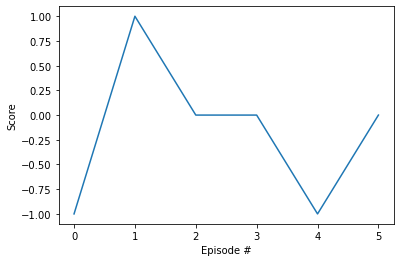

Episode 6	Average Score: -0.17

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [18]:
scores = train(10)

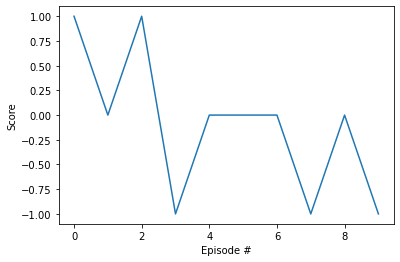

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
game

### Step 10: Watch a Smart Agent!

In [19]:
game.init()
score = 0
state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action, _, _ = agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  1.0
